CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 7 - Assignment
## Basic expectations
- \> = 99.4% accuracy
- < = 8000
- < = 15 epochs

## First step - Setup and Basic Skeleton

### Target:
- Setup
  - Get the set-up right
  - Set Transforms
  - Set Data Loader
  - Set Basic Working Code
  - Set Basic Training  & Test Loop
- Basic Skeleton

### Results:
- Epochs: 15
- Parameters: 350,600
- Training Batch size: 128
- Testing Batch size: 2048
- Training
  - Loss=0.0090
  - Batch_id=468
  - Accuracy=99.59%
- Testing
  - Average loss: 0.0340
  - Accuracy: 9900/10000 (99.00%)

### Analysis:
- Heavy Model for such a problem
- Model is slightly over-fitting, but consistent in the accuracy
- Testing acuracy not increasing though Training accuracy increasing showing overfitting
- Testing Accuracy is not near what we need
- Will change to lighter model in next run
- Later will try to remove overfitting with different options

### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 0

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

### [4. Getting the MNIST train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *??* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [5]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [6]:
train_batch_size = 128
test_batch_size = 2048

In [7]:
# train_args = {'batch_size': train_batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
# test_args = {'batch_size': test_batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
kwargs = {'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, **kwargs)

CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

In [8]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline

# batch_data, batch_label = next(iter(train_loader))

# fig = plt.figure()

# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [10]:
debug = True

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock3_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock3_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock1_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock3_5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock3_6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock1_7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        self.fc1 = nn.Linear(1568, 100, bias=False) # 7 * 7 * 32
        self.fc2 = nn.Linear(100, 10, bias=False)

    def forward(self, x):
        if (debug == True):
          print(f"Start: {x.shape}")
        x = self.convblock3_1(x)  # channel size 28 > 26  RF 1 > 3    J 1 > 1
        if (debug == True):
          print(f"Conv3_1: {x.shape}")
        x = self.convblock3_2(x)  # channel size 26 > 24  RF 3 > 5    J 1 > 1
        if (debug == True):
          print(f"Conv3_2: {x.shape}")
        x = self.convblock3_3(x)  # channel size 24 > 22  RF 5 > 7    J 1 > 1
        if (debug == True):
          print(f"Conv3_3: {x.shape}")
        x = self.pool1(x)         # channel size 22 > 11  RF 7 > 8    J 1 > 2
        if (debug == True):
          print(f"Pool1: {x.shape}")
        x = self.convblock1_4(x)  # channel size 11 > 11  RF 8 > 8    J 2 > 2
        if (debug == True):
          print(f"Conv1_4: {x.shape}")
        x = self.convblock3_5(x)  # channel size 11 > 9   RF 8 > 12   J 2 > 2
        if (debug == True):
          print(f"Conv3_5: {x.shape}")
        x = self.convblock3_6(x)  # channel size 9 > 7    RF 12 > 16  J 2 > 2
        if (debug == True):
          print(f"Conv3_6: {x.shape}")
        x = self.convblock1_7(x)  # channel size 7 > 7    RF 16 > 16  J 2 > 2
        if (debug == True):
          print(f"Conv1_7: {x.shape}")
        x = torch.flatten(x, start_dim=1)
        # x = x.view(-1, 1568)        # 7 * 7 * 32
        if (debug == True):
          print(f"Flatten: {x.shape}")
        x = self.fc1(x)
        if (debug == True):
          print(f"FC1: {x.shape}")
        x = self.fc2(x)
        if (debug == True):
          print(f"FC2: {x.shape}")
        return F.log_softmax(x, dim=-1)

In [11]:
mymodel = Net2().to(device)

summary(mymodel, input_size=(1, 28, 28))

Start: torch.Size([2, 1, 28, 28])
Conv3_1: torch.Size([2, 32, 26, 26])
Conv3_2: torch.Size([2, 64, 24, 24])
Conv3_3: torch.Size([2, 128, 22, 22])
Pool1: torch.Size([2, 128, 11, 11])
Conv1_4: torch.Size([2, 32, 11, 11])
Conv3_5: torch.Size([2, 64, 9, 9])
Conv3_6: torch.Size([2, 128, 7, 7])
Conv1_7: torch.Size([2, 32, 7, 7])
Flatten: torch.Size([2, 1568])
FC1: torch.Size([2, 100])
FC2: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv

In [12]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc= 100*correct/processed
  # train_losses.append(train_loss/len(train_loader))
  train_loss = train_loss/len(train_loader)

  return train_acc, train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc = (100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc, test_loss

In [13]:
debug = False
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = test(mymodel, device, test_loader, criterion)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

Epoch 1


Train: Loss=0.2939 Batch_id=468 Accuracy=45.39: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]


Test set: Average loss: 0.3057, Accuracy: 9093/10000 (90.93%)

Epoch 2


Train: Loss=0.1453 Batch_id=468 Accuracy=95.21: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]


Test set: Average loss: 0.0785, Accuracy: 9753/10000 (97.53%)

Epoch 3


Train: Loss=0.0092 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]


Test set: Average loss: 0.0647, Accuracy: 9797/10000 (97.97%)

Epoch 4


Train: Loss=0.0715 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]


Test set: Average loss: 0.0518, Accuracy: 9834/10000 (98.34%)

Epoch 5


Train: Loss=0.0204 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]


Test set: Average loss: 0.0443, Accuracy: 9858/10000 (98.58%)

Epoch 6


Train: Loss=0.0254 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]


Test set: Average loss: 0.0473, Accuracy: 9854/10000 (98.54%)

Epoch 7


Train: Loss=0.0721 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]


Test set: Average loss: 0.0392, Accuracy: 9875/10000 (98.75%)

Epoch 8


Train: Loss=0.0359 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]


Test set: Average loss: 0.0424, Accuracy: 9863/10000 (98.63%)

Epoch 9


Train: Loss=0.0087 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]


Test set: Average loss: 0.0394, Accuracy: 9879/10000 (98.79%)

Epoch 10


Train: Loss=0.0251 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Test set: Average loss: 0.0361, Accuracy: 9890/10000 (98.90%)

Epoch 11


Train: Loss=0.0532 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]


Test set: Average loss: 0.0357, Accuracy: 9890/10000 (98.90%)

Epoch 12


Train: Loss=0.0024 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

Epoch 13


Train: Loss=0.0022 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]


Test set: Average loss: 0.0354, Accuracy: 9892/10000 (98.92%)

Epoch 14


Train: Loss=0.0131 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]


Test set: Average loss: 0.0377, Accuracy: 9894/10000 (98.94%)

Epoch 15


Train: Loss=0.0090 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Test set: Average loss: 0.0340, Accuracy: 9900/10000 (99.00%)



CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

In [14]:
# utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

Text(0.5, 1.0, 'Test Accuracy')

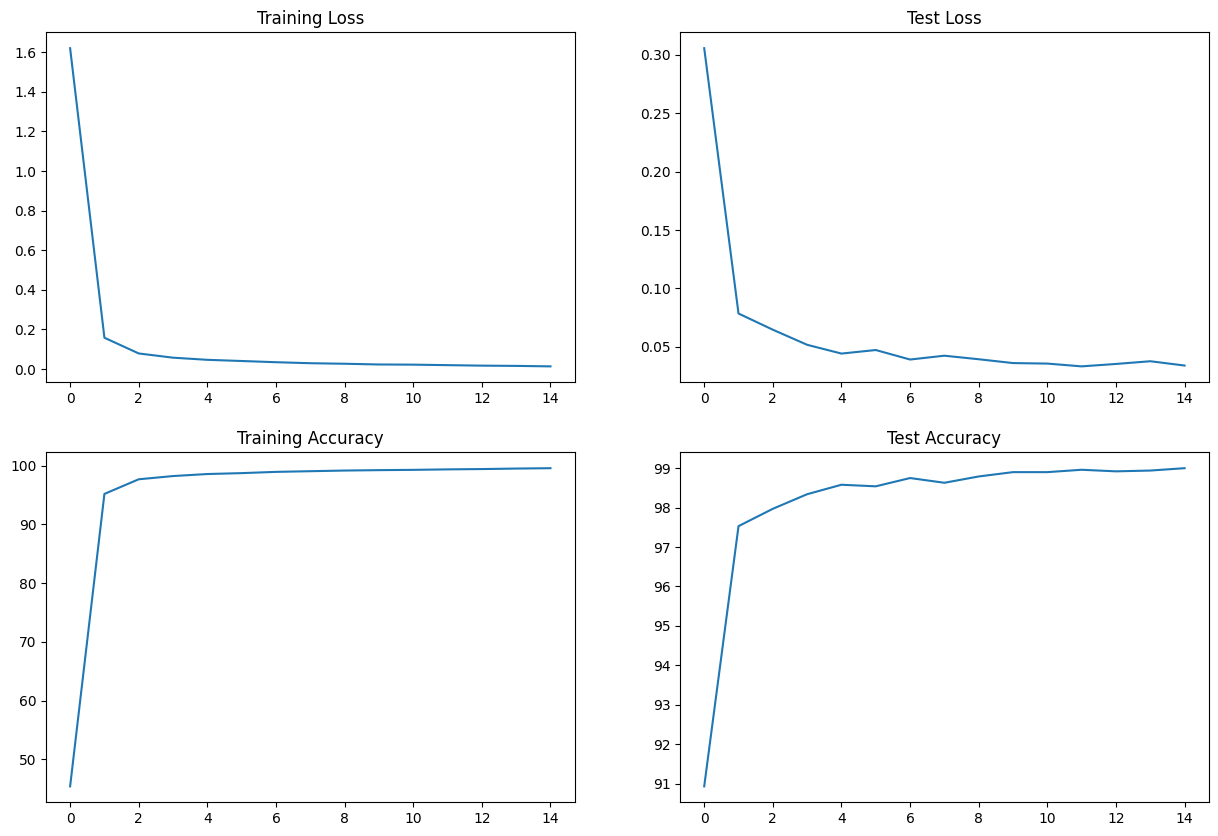

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")